In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import collections
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA


# ADD METRICS
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#NLTK - NLP Tokenizing and Cleaning
import nltk
from nltk import pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
# Tokenize and Pad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [4]:
data = pd.read_json("microaggressions-modified.json")
#clean_tags
data.tags = data.tags.str.join("|").apply(lambda x: re.sub(r'3yearsago|acces|beauty|colonialism|discussion|education|eurocentricism|eurocentrism|event|everything|family|faq|hair|institutional|internalization|macro|\bmarriage\b|marriagestatus|meta|orientalism|patriarchy|queer|reblog|reflection|region|relationship|resistance|school|west|\body|\*', r'', x))\
.apply(lambda y: re.sub(r'Skin Tone|citizenship|ethnicity|language|nationality|racism|skin tone', r'race', y))\
.apply(lambda z: re.sub(r"ability|ableism|invisibility|invisible", r"disability",z))\
.apply(lambda a: re.sub(r"Mind|mind|neurodiversity",r"mental health",a))\
.apply(lambda b: re.sub(r"immigrant status|immigration status", r"immigration",b))\
.apply(lambda c: re.sub(r"Sexuality|\bsex\b|sexism", r"sexuality",c))\
.apply(lambda d: re.sub(r"genderqueer|trans", r"gender",d))\
.apply(lambda e: re.sub(r"Survivor|submission|surivor|survivor", r"sexual assault",e))
data = pd.concat([data, data['tags'].str.get_dummies()], axis = 1)

In [5]:
print("Dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))

Dataset has 3710 rows and 13 columns


In [6]:
data.head()

,tags,text,age,body,class,disability,gender,immigration,mental health,race,religion,sexual assault,sexuality
0,race|race,Made to hold the Chinese flag for grade school...,0,0,0,0,0,0,0,1,0,0,0
1,race|race,Swing dancing during orientation week of colle...,0,0,0,0,0,0,0,1,0,0,0
2,gender|sexual assault,I text a male friend to ask if he wants to see...,0,0,0,0,1,0,0,0,0,1,0
3,race,Roommates seek my approval for whether the sti...,0,0,0,0,0,0,0,1,0,0,0
4,race,"(At a playground clapping game) ""I went to a C...",0,0,0,0,0,0,0,1,0,0,0


In [7]:
#Rows with empty values either in the tags or the text and reindex
bad_indices = list(set(np.where(data[["tags", "text"]] == "")[0]))
data.drop(data.index[bad_indices], inplace = True)
data = data.reset_index(drop=True)

In [8]:
print("After culling the empty values, the dataset now has {} rows and {} columns".format(data.shape[0], data.shape[1]))

After culling the empty values, the dataset now has 3509 rows and 13 columns


In [9]:
#Class labels
list_classes = ["age","body","class", "disability", "gender", "immigration"	"mental health", "race", "religion", "sexual assault", "sexuality"]

#Read the data
train, test, train_labels, test_labels = train_test_split(data.iloc[:, 1],data.iloc[:,2:],test_size=0.20,train_size=0.80, stratify = data["race"])

print(train.shape, train_labels.shape)
print(test.shape, test_labels.shape)

(2807,) (2807, 11)
(702,) (702, 11)


In [10]:
# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(train, total=len(train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')


100%|██████████| 2807/2807 [00:00<00:00, 89366.50it/s]

153184 words.
20143 unique words.
10 Most common words in the dataset:
"I" "a" "to" "the" "and" "my" "of" "me" "in" "that"


In [11]:
data_classes = data
counts = []
categories = list(data.columns[2:].values)
for i in categories:
    counts.append((i, data[i].sum()))
data_stats = pd.DataFrame(counts, columns=['Classes', '#Microagressions'])
data_stats


,Classes,#Microagressions
0,age,34
1,body,226
2,class,232
3,disability,114
4,gender,1569
5,immigration,33
6,mental health,33
7,race,1665
8,religion,114
9,sexual assault,98


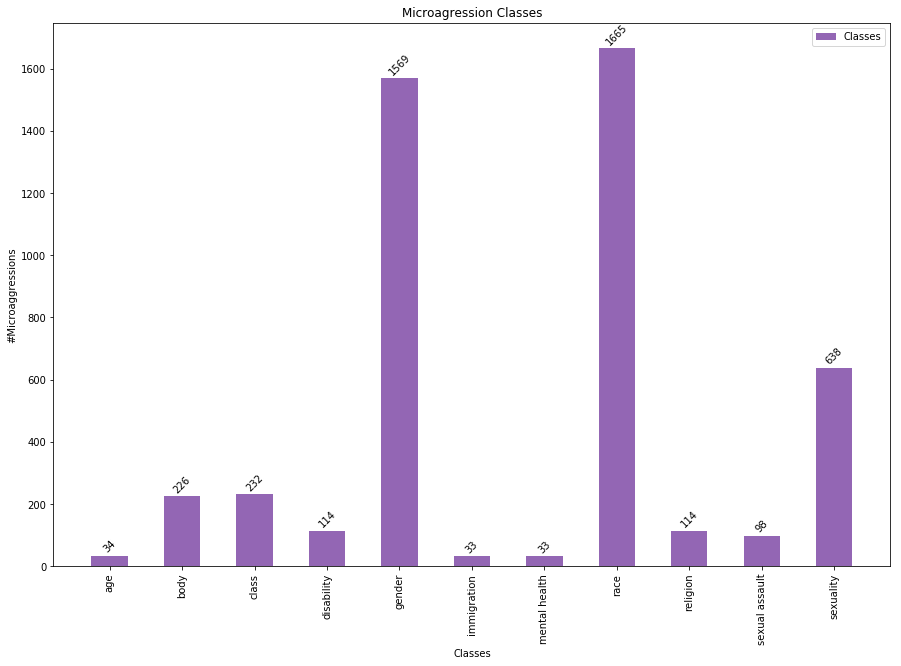

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.5
opacity = 0.6
labels = data_stats["#Microagressions"]

rects1 = plt.bar(data_stats["Classes"], data_stats["#Microagressions"], bar_width,
                 alpha=opacity,
                 color='indigo',
                 label='Classes')
plt.xlabel('Classes')
plt.ylabel('#Microaggressions')
plt.title('Microagression Classes')
plt.xticks(np.arange(len(data_stats["Classes"])), data_stats["Classes"], rotation='vertical')
plt.legend()


for rect, label in zip(rects1, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', rotation = 45)

A few things to note so far - class imbalance and stopwords need to be filtered

In [13]:
# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(train))
tokenized_train = tokenizer.texts_to_sequences(train)
tokenized_test = tokenizer.texts_to_sequences(test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))


Vocab size: 10107
Longest comment size: 858
Average comment size: 55.12326327039544
Stdev of comment size: 38.16009509247182
Max comment size: 169

Sequence 1
  Input:  I'm walking back to my apartment in the middle of the day in a neighborhood with very few Asian people when a stranger calls out, "Ni hao" at me. When I ignore him, he says, "I said, NI HAO," in a noticeably angry tone. I'm a 21 year-old Asian American man in Brooklyn.Angry and annoyed that a stranger would assume I speak a different language because of the way I look, but moreover literally afraid for my physical safety in a situation where I should feel safe.
  Output: [17, 285, 171, 3, 6, 723, 9, 4, 228, 8, 4, 159, 9, 2, 724, 18, 142, 314, 92, 37, 29, 2, 654, 610, 52, 1206, 1207, 16, 7, 29, 1, 1208, 68, 24, 100, 1, 64, 1206, 1207, 9, 2, 3934, 81, 725, 17, 2, 510, 84, 82, 92, 89, 69, 9, 1490, 81, 5, 353, 10, 2, 654, 78, 756, 1, 184, 2, 286, 364, 42, 8, 4, 149, 1, 99, 35, 5566, 1631, 511, 15, 6, 1209, 1491, 9, 2, 1310,

A vocabulary of 17110 words has been shrunk to 8883

In [14]:
word_count_distribution = tokenizer.word_counts.items()
sorted(word_count_distribution, key=lambda kv: kv[1], reverse = True)


[('i', 5189),
 ('a', 4895),
 ('to', 4306),
 ('the', 4064),
 ('and', 3550),
 ('my', 3164),
 ('me', 3131),
 ('of', 2271),
 ('in', 2232),
 ('that', 1994),
 ('you', 1913),
 ('was', 1368),
 ('it', 1175),
 ('is', 1174),
 ('for', 1151),
 ('at', 1144),
 ("i'm", 1070),
 ('with', 1047),
 ('feel', 971),
 ('like', 949),
 ('are', 909),
 ('on', 884),
 ('made', 874),
 ('he', 870),
 ('not', 857),
 ('white', 852),
 ('have', 842),
 ('as', 809),
 ('when', 764),
 ('about', 763),
 ('be', 760),
 ('this', 714),
 ('so', 704),
 ('she', 693),
 ('but', 691),
 ('am', 673),
 ('people', 660),
 ('they', 614),
 ('her', 609),
 ("don't", 589),
 ('an', 589),
 ('because', 585),
 ('just', 583),
 ('if', 538),
 ('or', 529),
 ('black', 525),
 ('from', 503),
 ('we', 501),
 ('who', 499),
 ('what', 497),
 ('woman', 469),
 ('out', 454),
 ('all', 451),
 ('friend', 449),
 ('one', 439),
 ('your', 436),
 ('male', 425),
 ('know', 412),
 ('up', 412),
 ("you're", 408),
 ('no', 401),
 ("it's", 394),
 ('do', 394),
 ('said', 389),
 ('girl

In [15]:
embedding_dim = 300

# Get embeddings
embeddings_index = {}
f = open('wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))


FileNotFoundError: [Errno 2] No such file or directory: 'wiki.en.vec'

In [ ]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [ ]:
import h5py
with h5py.File('embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [ ]:
# Load embeddings# Load e 
with h5py.File('embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

In [ ]:
import keras.backend
from keras.models import Sequential
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam

# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layers
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))

# Add Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(11, activation='sigmoid'))

# Summarize the model
model.summary()


In [ ]:
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        print("After init")
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch end 1")
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, train_labels, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='model.best.hdf5',validation_data=(X, y), interval=1)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')

# Set variables
batch_size = 64
epochs = 5

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=1, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(processed_X_test, verbose=0)


In [ ]:
#preprocessing
def nltk_preprocess(data):
    '''This function preprocesses a data frame, specifing a text_column, 
    and strips down the document to cleaned, individualized word tokens without
    stop words and other excessive parts of speech and eventually rejoins the remaining words.
    '''
    #Initializes stop words and new column creation
    stop = stopwords.words('english')
    
    
    #Initialize Lemmatizer object and final list of lemmatized words
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None # for easy if-statement
        
    def lemmatized(word, tag):
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            lemma = str(lemmatizer.lemmatize(word))
        else:
            lemma = str(lemmatizer.lemmatize(word, pos=wntag))
        return lemma

    data = data.apply(lambda x: re.sub(r'\d+', r' ', x)).apply(lambda y: re.sub(r'\W+', r' ', y)).apply(lambda z: re.sub(r"_+",r" ",z))
    data = data.str.lower()
    data = data.apply(word_tokenize)
    data = data.apply(lambda x: [item for item in x if item not in stop])
    data = data.apply(pos_tag)
    data = data.apply(lambda x: [lemmatized(word, tag) for (word, tag) in x])
    data = data.apply(lambda x: ' '.join(x))
    return data

data["text"] = nltk_preprocess(data["text"])

In [ ]:
train = train.reset_index().drop(['index'], axis=1)
train_labels = train_labels.reset_index().drop(['index'], axis=1)
dev = dev.reset_index().drop(['index'], axis=1)
dev_labels = dev_labels.reset_index().drop(['index'], axis=1)
test = test.reset_index().drop(['index'], axis=1)
test_labels = test_labels.reset_index().drop(['index'], axis=1)

In [ ]:
pipe1 = Pipeline([('cv', CountVectorizer(min_df=.02, max_df=.3, ngram_range=(1,3))),
                  ('tfidf', TfidfTransformer()),
                  ('clf', OneVsRestClassifier(MultinomialNB()))])

#categories = list(data.columns[2:].values) <- refresher for categories
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    pipe1.fit(train, train_labels[category])
    # compute the testing accuracy
    prediction = pipe1.predict(dev)
    print('Test accuracy is {}'.format(accuracy_score(dev_labels[category], prediction)))

In [ ]:
pipe2 = Pipeline([('cv', CountVectorizer(min_df=.02, max_df=.3, ngram_range=(1,3))),
                  ('tfidf', TfidfTransformer()),
                  ('clf', OneVsRestClassifier(LinearSVC()))])

#categories = list(data.columns[2:].values) <- refresher for categories
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    pipe2.fit(train, train_labels[category])
    # compute the testing accuracy
    prediction = pipe2.predict(dev)
    print('Test accuracy is {}'.format(accuracy_score(dev_labels[category], prediction)))

In [ ]:
pipe3 = Pipeline([('cv', CountVectorizer(min_df=.02, max_df=.3, ngram_range=(1,3))),
                  ('tfidf', TfidfTransformer()),
                  ('clf', OneVsRestClassifier(LogisticRegression()))])

#categories = list(data.columns[2:].values) <- refresher for categories
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    pipe3.fit(train, train_labels[category])
    # compute the testing accuracy
    prediction = pipe2.predict(dev)
    print('Test accuracy is {}'.format(accuracy_score(dev_labels[category], prediction)))

In [ ]:
pipe1.fit(train, train_labels)
pipe2.fit(train, train_labels)
pipe3.fit(train, train_labels)

pipe_pred_1 = pipe1.predict(test)
print(classification_report(pipe_pred_1, test_labels, target_names = categories))

In [ ]:
pipe_pred_2 = pipe2.predict(test)
print(classification_report(pipe_pred_2, test_labels, target_names = categories))

In [ ]:
pipe_pred_3 = pipe3.predict(test)
print(classification_report(pipe_pred_3, test_labels, target_names = categories))

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import os
import tensorflow as tf
import nltk
import gc
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('/Users/robertdeng/Google Drive/Data Science/W266/allie/crawl-300d-2M.vec'))
del embeddings_index['2000000']

In [ ]:
len(embeddings_index) 

In [ ]:
max_features = 100000
maxlen = 180

In [ ]:
plt.hist([len(i) for i in data.text], bins=100)
plt.ylabel('Max Length Histogram');

In [ ]:
print(np.mean([len(i) for i in data.text]), max([len(i) for i in data.text]))

In [ ]:
#Create the dictionary whose keys contains all words in train dataset that also shown 
#in FastText word embeddings.
lst = []
for line in train["text"]:
    lst += line.split()
    
count = Counter(lst)
for k in list(count.keys()):
    if k not in embeddings_index:
        del count[k]
        
len(count)

In [ ]:
count = dict(sorted(count.items(), key=lambda x: -x[1]))
count = {k:v for (k,v) in count.items() if v >= 2}
len(count)

In [ ]:
count = dict(zip(list(count.keys()),range(1,64349 + 1)))
embedding_matrix = {}
for key in count:
    embedding_matrix[key] = embeddings_index[key]

In [ ]:
W = np.zeros((1,300))
W = np.append(W, np.array(list(embedding_matrix.values())),axis=0)
W = W.astype(np.float32, copy=False)
W.shape

In [ ]:
#Same Step for text dataset.
lst = []
for line in test["text"]:
    lst += line.split()
    
count_test = Counter(lst)
for k in list(count_test.keys()):
    if k not in embedding_matrix:
        del count_test[k]
    else:
        count_test[k] = count[k]

In [ ]:
len(count_test)
#Release Memory
del lst
gc.collect()

In [ ]:
for i in range(len(train)):
    temp = train.iloc[i, 0].split()
    for word in temp[:]:
        if word not in count:
            temp.remove(word)
    for j in range(len(temp)):
        temp[j] = count[temp[j]]
    train.iloc[i, 0] = temp

In [ ]:
for i in range(len(test)):
    temp = test.iloc[i, 0].split()
    for word in temp[:]:
        if word not in count_test:
            temp.remove(word)
    for j in range(len(temp)):
        temp[j] = count_test[temp[j]]
    test.iloc[i, 0] = temp

In [ ]:
#Pad sequence to max length parameter
train_x = sequence.pad_sequences(list(train["text"]), maxlen = maxlen)
test_x = sequence.pad_sequences(list(test["text"]), maxlen = maxlen)

In [ ]:
del embeddings_index
gc.collect()

**CNN Placeholder & Model Construction**

In [ ]:
filter_sizes = [1,2,3,4,5]
num_filters = 32
batch_size = 256
#This large batch_size is specially for this case. Usually it is between 64-128.
num_filters_total = num_filters * len(filter_sizes)
embedding_size = 300
sequence_length = 170
num_epochs = 3 #Depends on your choice.
dropout_keep_prob = 0.9

In [ ]:
input_x = tf.placeholder(tf.int32, [None, sequence_length], name = "input_x")
input_y = tf.placeholder(tf.float32, [None,6], name = "input_y") 

In [ ]:
embedded_chars = tf.nn.embedding_lookup(W, input_x)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)

In [ ]:
def CNN(data):
    pooled_outputs = []
    
    for i, filter_size in enumerate(filter_sizes):
        
        filter_shape = [filter_size, embedding_size, 1, num_filters]
        
        w = tf.Variable(tf.truncated_normal(filter_shape,stddev = 0.05), name = "w")
        b = tf.Variable(tf.truncated_normal([num_filters], stddev = 0.05), name = "b")
            
        conv = tf.nn.conv2d(
            data,
            w,
            strides = [1,1,1,1],
            padding = "VALID",
            name = "conv"
        )
        h = tf.nn.relu(tf.nn.bias_add(conv, b), name = "relu")
        pooled = tf.nn.max_pool(
            h,
            ksize = [1, sequence_length - filter_size + 1, 1, 1],
            strides = [1,1,1,1],
            padding = "VALID",
            name = "pool"
        )
        
        pooled_outputs.append(pooled)
    
    #return pooled_outputs
    h_pool = tf.concat(pooled_outputs, 3)
    h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
    return h_pool_flat

In [ ]:
h_pool_flat = CNN(embedded_chars_expanded)
h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

In [ ]:
#In the first dense layer, reduce the node to half.
wd1 = tf.Variable(tf.truncated_normal([num_filters_total, int(num_filters_total/2)], stddev=0.05), name = "wd1")
bd1 = tf.Variable(tf.truncated_normal([int(num_filters_total/2)], stddev = 0.05), name = "bd1")
layer1 = tf.nn.xw_plus_b(h_drop, wd1, bd1, name = 'layer1') # Do wd1*h_drop + bd1
layer1 = tf.nn.relu(layer1)

In [ ]:
#Second dense layer, reduce the outputs to 6.
wd2 = tf.Variable(tf.truncated_normal([int(num_filters_total/2),6], stddev = 0.05), name = 'wd2')
bd2 = tf.Variable(tf.truncated_normal([6], stddev = 0.05), name = "bd2")
layer2 = tf.nn.xw_plus_b(layer1, wd2, bd2, name = 'layer2') 
prediction = tf.nn.sigmoid(layer2)# Make it to be 0-1.
#pred_clipped = tf.clip_by_value(prediction, 1e-10, 0.9999999) 
#For some special loss function clip is necessary. Like log(x).

In [ ]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = layer2, labels = input_y))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0007).minimize(loss)
#when learning rate set to 0.0007, the mean of threat is not 0, but when it is 0.001, it becomes 0 again.
#Learning rates usually is small for CNN compared with pure neural network. 
#Need to define a approriate learning rate before you run on the whole dataset.
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(prediction), input_y), tf.float32))
#correct_prediction = tf.equal(tf.argmax(input_y, 1), tf.argmax(prediction, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
#Define batch generation function.
def generate_batch(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    l = 0
    for epoch in range(num_epochs):
        l += 1
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [ ]:
#For Test data. Can use generate_batch function.
def blocks(data, block_size):
    data = np.array(data)
    data_size = len(data)
    nums = int((data_size-1)/block_size) + 1
    for block_num in range(nums):
        if block_num == 0:
            print("prediction start!")
        start_index = block_num * block_size
        end_index = min((block_num + 1) * block_size, data_size)
        yield data[start_index:end_index]

**Blocks and Batches**

In [ ]:
train_labels.columns

In [ ]:
batch1 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch2 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch3 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch4 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch5 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch6 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch7 = generate_batch(list(zip(np.array(train.text), train_labels['age'], train_labels['body'], train_labels['class'], train_labels['disability'], train_labels['gender'], train_labels['immigration'], train_labels['mental health'], train_labels['race'], train_labels['sexual assault'], train_labels['immigration'], train_labels['sexuality'])), batch_size, 1)

In [ ]:
batch_bag = [batch1,batch2,batch3,batch4,batch5,batch6,batch7]

In [ ]:
test_blocks = blocks(list(np.array(test_x)), 1000)

In [ ]:
[i for i in batch1]

In [ ]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init_op)
    i = 0
    for batches in batch_bag:
        i += 1
        print('Epoch: ' + str(i) + ' start!')
        avg_acc = 0
        avg_loss = 0
        for batch in batches:
            batch = pd.DataFrame(batch, columns = ['text', 'age', 'body', 'class', 'disability', 'gender', 'immigration', 'mental health', 'race', 'religion', 'sexual assault', 'sexuality'])
            x_batch = pd.DataFrame(list(batch['text']))
            y_batch = batch.loc[:, batch.columns != 'text']
            _,c, acc = sess.run([optimizer, loss, accuracy],feed_dict = {input_x: x_batch, input_y: y_batch})
            avg_loss += c
            avg_acc += acc
        avg_loss = avg_loss/624
        avg_acc = avg_acc/624
        print('Epoch:' + str(i) + ' loss is ' + str(avg_loss) + ', train accuracy is ' + str(avg_acc))
        #print('Evaluation Accuracy: ')
        #print(accuracy.eval({input_x: val_x, input_y: yval}))
    
    print('Training Finish!')
    
    df = pd.DataFrame()
    for block in test_blocks:
        block = pd.DataFrame(block)
        pred = sess.run(prediction, feed_dict = {input_x: block})
        df = df.append(pd.DataFrame(pred))
    
    print('Prediction Finish!')

In [ ]:
df.round().mean()